$$\Huge \text{RAPORT}$$
$$\huge \text{LISTA 2}$$
$$\large \text{Autorzy: Katarzyna Rudzińska, Jagoda Płócienniczak}$$

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency, fisher_exact, kendalltau, beta, chi2  

In [171]:
# np.set_printoptions(legacy='1.25')

Niniejszy raport stanowi kontynuację analizy opinii pracowników na temat szkoleń organizowanych przez firmę, rozpoczętej w poprzednim opracowaniu. Główna część analizy dotyczy oceny skuteczności szkolenia „Efektywna komunikacja w zespole” oraz identyfikacji czynników demograficznych (takich jak płeć, wiek czy staż pracy), które mogą mieć wpływ na poziom zadowolenia uczestników. W dalszej części przeprowadzono testy statystyczne służące weryfikacji hipotez dotyczących rozkładów odpowiedzi oraz zależności pomiędzy zmiennymi. Zastosowano między innymi testy chi-kwadrat, testy Fishera oraz testy Freemana-Haltona.

Ze względu na fakt, iż przeprowadzona analiza obejmuje rozwiązanie zadań podzielonych na pięć głównych części, a w niektórych z nich odwołano się do wcześniej zdefiniowanych pojęć i zmiennych z poprzedniego raportu, ich implementacja została powtórzona również w niniejszym opracowaniu. Pozwala to na zachowanie spójności analizy oraz zapewnia pełną czytelność bieżącego raportu.

In [2]:
data = pd.read_csv('ankieta.csv', encoding='Windows-1250', sep=';')
data['DZIAŁ'] = data['DZIAŁ'].astype("category")
data['CZY_KIER'] = data['CZY_KIER'].astype("category")
data['PŁEĆ'] = data['PŁEĆ'].astype("category")

In [3]:
def categorize_age(age):
    if age <= 35:
        return "<=35"
    elif 36 <= age <= 45:
        return "36-45"
    elif 46 <= age <= 55:
        return "46-55"
    else:
        return ">55"

data["WIEK_KAT"] = data["WIEK"].apply(categorize_age)
data['WIEK_KAT'] = data['WIEK_KAT'].astype("category")

In [4]:
def is_satisfied(satisfaction_lvl):
    if satisfaction_lvl == -2 or satisfaction_lvl == -1:
        return 'NIE'
    else:
        return 'TAK'

data["CZY_ZADOW"] = data["PYT_2"].apply(is_satisfied)
data["CZY_ZADOW"] = data["CZY_ZADOW"].astype("category")

## CZĘŚĆ I

### ZADANIE 1
    W ankiecie przedstawionej na poprzedniej liście pracownicy zostali poproszeni o wyrażenie opinii na temat skuteczności szkolenia "Efektywna komunikacja w zespole" zorganizowanego przez firmę. Wśród próbki 200 pracowników (losowanie proste ze zwracaniem) uzyskano wyniki:
        • 14 pracowników - bardzo niezadowolonych,
        • 17 pracowników - niezadowolonych,
        • 40 pracowników - nie ma zdania,
        • 100 pracowników - zadowolonych,
        • 29 pracowników - bardzo zadowolonych,
    Na podstawie danych wyznacz przedział ufności dla wektora prawodobieństw opisującego stopień zadowolenia ze szkolenia. Przyjmij poziom ufności 0,95.

In [7]:
n = 200
counts = np.array([14, 17, 40, 100, 29])
labels = ["bardzo niezadowoleni", "niezadowoleni", "neutralni", "zadowoleni", "bardzo zadowoleni"]
proportions = counts / n
alpha = 0.05

ci_lower = []
ci_upper = []

for x in counts:
    lower = beta.ppf(alpha / 2, x, n - x + 1)
    upper = beta.ppf(1 - alpha / 2, x + 1, n - x)
    ci_lower.append(lower)
    ci_upper.append(upper)

ci_df = pd.DataFrame({
    "Kategoria": labels,
    "Liczba": counts,
    "Proporcja": proportions,
    "Dolna granica CI": ci_lower,
    "Górna granica CI": ci_upper
})

ci_df = ci_df.round(4)
ci_df


,Kategoria,Liczba,Proporcja,Dolna granica CI,Górna granica CI
0,bardzo niezadowoleni,14,0.070,0.0388,0.1147
1,niezadowoleni,17,0.085,0.0503,0.1326
2,neutralni,40,0.200,0.1469,0.2622
3,zadowoleni,100,0.500,0.4287,0.5713
4,bardzo zadowoleni,29,0.145,0.0993,0.2016


Na podstawie próby 200 pracowników oszacowano proporcje ocen szkolenia „Efektywna komunikacja w zespole” w pięciu kategoriach. Dla każdej kategorii wyznaczono 95% przedział ufności metodą Cloppera-Pearsona, co pozwala oszacować niepewność tych proporcji w populacji wszystkich pracowników.

Najwięcej osób zadeklarowało, że są **zadowoleni** (50% próby), a ich przedział ufności to (42.87%, 57.13%). Drugą najliczniejszą grupą byli pracownicy **neutralni** (20%, CI: 14.69%, 26.22%). Stosunkowo niewielki odsetek osób był **bardzo niezadowolony** (7%) lub **niezadowolony** (8.5%).Przedziały te informują nas, że z 95% pewnością prawdziwe proporcje ocen w całej populacji znajdują się w wyznaczonych granicach. Największa niepewność dotyczy skrajnych kategorii (bardzo niezadowoleni i bardzo zadowoleni), co wynika z mniejszej liczby obserwacji w tych grupach.

### ZADANIE 2 
    Napisz funkcję, która wyznacza wartość poziomu krytycznego w następujących testach:
        • chi-kwadrat Pearsona
        • chi-kwadrat największej wiarogodności
    służących do weryfikacji hipotezy H0 : p = p0 przy hipotezie alternatywnej H1 : p = p0 na podstawie obserwacji x wektora losowego X z rozkładu wielomianowego z parametrami n i p.

In [45]:
def test_chi_squared(x, p0, n):
    import numpy as np
    from scipy.stats import chi2

    x = np.array(x)
    p0 = np.array(p0)

    if not np.isclose(np.sum(p0), 1):
        raise ValueError("Rozkład p0 musi sumować się do 1.")
    if not np.isclose(np.sum(x), n):
        raise ValueError("Suma obserwacji x musi być równa n.")

    expected = n * p0
    mask = expected > 0
    df = np.count_nonzero(mask) - 1

    # Pearson chi^2
    chi2_pearson = np.sum((x[mask] - expected[mask]) ** 2 / expected[mask])
    p_pearson = 1 - chi2.cdf(chi2_pearson, df)

    # Likelihood-ratio chi^2 (G-test)
    with np.errstate(divide='ignore', invalid='ignore'):
        terms = np.where(x != 0, x * np.log(x / expected), 0)
    chi2_likelihood = 2 * np.sum(terms)
    p_likelihood = 1 - chi2.cdf(chi2_likelihood, df)

    return {
        "Pearson chi^2": chi2_pearson,
        "Pearson p-value": p_pearson,
        "Likelihood ratio chi^2": chi2_likelihood,
        "Likelihood ratio p-value": p_likelihood
    }


In [46]:
x = [14, 17, 40, 100, 29]
n = sum(x)
p0 = [0.1, 0.1, 0.2, 0.5, 0.1]  # przykładowy teoretyczny rozkład

test_chi_squared(x, p0, n)

{'Pearson chi^2': 6.3,
 'Pearson p-value': 0.1778363264982168,
 'Likelihood ratio chi^2': 6.038144239875159,
 'Likelihood ratio p-value': 0.1963176909242157}

W zadaniu rozważamy dwa testy statystyczne służące do weryfikacji hipotezy zerowej $ H_0: \mathbf{p} = \mathbf{p}_0 $, gdzie $ \mathbf{p} $ to nieznany wektor prawdopodobieństw rozkładu wielomianowego, a $ \mathbf{p}_0 $ to hipotetyczny (zadany) rozkład teoretyczny. Oba testy opierają się na porównaniu zaobserwowanych liczności $ \mathbf{x} = (x_1, \ldots, x_k) $ z licznościami oczekiwanymi $ \mathbf{E} = n \cdot \mathbf{p}_0 $, gdzie $ n $ to liczność próby.

#### 1. Test chi-kwadrat Pearsona

Statystyka testowa Pearsona dana jest wzorem:
$
\chi^2_P = \sum_{i=1}^k \frac{(x_i - np_{0i})^2}{np_{0i}}
$

Wartość tej statystyki porównuje się z rozkładem chi-kwadrat o $ k-1 $ stopniach swobody. Jeżeli obliczona statystyka przekracza wartość krytyczną, odrzucamy hipotezę zerową.

#### 2. Test chi-kwadrat największej wiarygodności (test log-likelihood ratio)

Drugi test oparty jest na statystyce logarytmu stosunku wiarygodności (likelihood ratio):
$
\chi^2_{LR} = 2 \sum_{i=1}^k x_i \ln\left( \frac{x_i}{np_{0i}} \right)
$
z konwencją, że $ 0 \cdot \ln(0) = 0 $. Podobnie jak w teście Pearsona, ta statystyka ma asymptotycznie rozkład chi-kwadrat z $ k - 1 $ stopniami swobody.

#### Poziom krytyczny i wartość p

Poziom krytyczny to wartość statystyki testowej, dla której $ p $ -value równa się przyjętemu poziomowi istotności (np. 0.05). W praktyce oblicza się wartość statystyki testowej dla danych obserwacji, a następnie wyznacza się tzw. wartość p (p-value), czyli prawdopodobieństwo otrzymania równie ekstremalnej lub bardziej ekstremalnej wartości przy założeniu, że $ H_0 $ jest prawdziwa:

$
\text{p-value} = P(\chi^2 > \text{statystyka testowa})
$

Jeśli $ \text{p-value} < \alpha $, gdzie $ \alpha $ to poziom istotności (np. 0.05), to hipoteza $ H_0 $ jest odrzucana.

Oba testy są asymptotycznie równoważne przy dużych próbach, jednak test największej wiarygodności lepiej radzi sobie przy małych licznościach (zwłaszcza gdy niektóre wartości oczekiwane są < 5).


### ZADANIE 3
    Na podstawie danych z ankiety z poprzedniej listy zweryfikuj hipotezę, że w grupie pracowników zatrudnionwych w Dziale Produktowym rozkład odpowiedzi na pytanie "Jak bardzo zgadzasz się ze stwierdzeniem, że firma zapewnia odpowiednie wsparcie i materiały umożliwiające skuteczne wykorzystanie w praktyce wiedzy zdobytej w trakcie szkoleń?" jest równomierny, tzn. jest jednakowe prawdopodobieństwo, że pracownik zatrudniony w Dziale Produkcjnym udzielił odpowiedzi "zdecydowanie się nie zgadzam", "nie zgadzam się", "nie mam zdania", "zgadzam się", "zdecydowanie się zgadzam" na pytanie PYT_1. Przyjmij poziom istotności 0,05. Skorzystaj z funkcji napisanej w zadaniu 2.

In [53]:
df_pd = data[data["DZIAŁ"] == "PD"]
df_pd = df_pd.copy()


odpowiedzi_map = {
    -3: "zdecydowanie się nie zgadzam",
    -2: "nie zgadzam się",
    -1: "nie mam zdania",
     0: "zgadzam się",
     1: "zdecydowanie się zgadzam"
}

kategorie = [
    "zdecydowanie się nie zgadzam",
    "nie zgadzam się",
    "nie mam zdania",
    "zgadzam się",
    "zdecydowanie się zgadzam"
]

df_pd["PYT_1_opis"] = df_pd["PYT_1"].map(odpowiedzi_map)

x = df_pd["PYT_1_opis"].value_counts().reindex(kategorie, fill_value=0).values
n = x.sum()
p0 = [1/5] * 5

wynik = test_chi_squared(x, p0, n)

for nazwa, wartosc in wynik.items():
    print(f"{nazwa}: {wartosc:.4f}")


Pearson chi^2: 89.4943
Pearson p-value: 0.0000
Likelihood ratio chi^2: 85.9514
Likelihood ratio p-value: 0.0000


## CZĘŚĆ II

### ZADANIE 4
    Zapoznaj się z funkcjami służącymi do wykonania testu Fishera oraz testu Freemana-Haltona.

In [ ]:
from scipy.stats import fisher_exact

table_fisher = np.array([[10, 20], [5, 15]])

oddsratio, p_value_fisher = fisher_exact(table_fisher)

print("Test Fishera:")
print(f"Odsetek szans: {oddsratio}")
print(f"Wartość p: {p_value_fisher}")


Test Fishera:
Odsetek szans: 1.5
Wartość p: 0.7536263339838003


In [69]:
def freeman_halton(observed, num_simulations=10000, random_state=None):
    """
    Dokładny test Freemana-Haltona (Monte Carlo) dla tabel kontyngencji większych niż 2x2.
    
    Parameters:
        observed (np.array): Tablica kontyngencji (2D).
        num_simulations (int): Liczba permutacji Monte Carlo (np. 10000).
        random_state (int): Opcjonalny seed generatora.

    Returns:
        stat_obs (float): Statystyka testowa (chi^2 z danych).
        p_value (float): P-wartość oszacowana metodą Monte Carlo.
    """
    rng = np.random.default_rng(random_state)
    observed = np.array(observed)
    
    # Sprawdzenie wejścia
    if observed.ndim != 2:
        raise ValueError("Tylko tablice 2D są obsługiwane.")
    
    row_totals = np.sum(observed, axis=1)
    col_totals = np.sum(observed, axis=0)
    total = np.sum(observed)

    # Oblicz statystykę z oryginalnych danych
    stat_obs, _, _, _ = chi2_contingency(observed, correction=False)

    # Generuj permutacje i licz ile razy statystyka >= stat_obs
    count = 0
    for _ in range(num_simulations):
        # Wylosuj permutację zgodną z marginesami (row/col sums)
        table = np.zeros_like(observed)
        flat = np.concatenate([
            [i] * row_totals[i] for i in range(len(row_totals))
        ])
        rng.shuffle(flat)
        idx = 0
        for j in range(len(col_totals)):
            col = flat[idx:idx + col_totals[j]]
            for i in range(len(row_totals)):
                table[i, j] = np.sum(col == i)
            idx += col_totals[j]

        stat_sim, _, _, _ = chi2_contingency(table, correction=False)
        if stat_sim >= stat_obs:
            count += 1

    p_value = count / num_simulations
    return stat_obs, p_value


In [58]:
observed = np.array([
    [10, 15, 5],
    [20, 10, 5]
])

stat, p = freeman_halton(observed, num_simulations=10000, random_state=42)
print(f"Statystyka chi^2: {stat:.4f}")
print(f"P-wartość (Monte Carlo): {p:.4f}")


Statystyka chi^2: 3.9722
P-wartość (Monte Carlo): 0.1317


### Test Freemana-Haltona 

Test Freemana-Haltona jest rozszerzeniem testu dokładnego Fishera dla tabel kontyngencji większych niż 2×2. Służy do testowania niezależności między dwiema zmiennymi kategorycznymi, gdy obserwacje przedstawione są w postaci dwuwymiarowej tablicy częstości.

Podobnie jak test Fishera, test Freemana-Haltona opiera się na dokładnych wyliczeniach prawdopodobieństw dla wszystkich możliwych tabel o tych samych marginesach (czyli sumach wierszy i kolumn) co tabela zaobserwowana. Dzięki temu unika się stosowania rozkładu asymptotycznego, co jest szczególnie istotne w analizie małych prób, gdzie założenia testu chi-kwadrat mogą być niespełnione.

#### Zasada działania testu

Hipoteza zerowa (H₀) w tym teście zakłada, że badane zmienne są niezależne, a więc zaobserwowana tablica mogła powstać losowo przy zadanych marginesach. W praktyce polega to na tym, że przy ustalonych sumach wierszy i kolumn rozważane są wszystkie możliwe tablice kontyngencji, jakie mogą wystąpić. Każdej z tych tabel przypisuje się prawdopodobieństwo wystąpienia pod warunkiem prawdziwości hipotezy zerowej. Następnie porównuje się wartość statystyki testowej (najczęściej chi-kwadrat Pearsona) obliczoną dla tabeli zaobserwowanej z wartościami tej statystyki dla wszystkich możliwych tabel. P-wartość w teście określana jest jako proporcja tych tabel, dla których statystyka testowa przyjmuje wartości większe lub równe niż w przypadku danych obserwowanych.

Najczęściej stosowaną statystyką jest klasyczna statystyka chi-kwadrat Pearsona:

$
\chi^2 = \sum_{i,j} \frac{(O_{ij} - E_{ij})^2}{E_{ij}}
$

gdzie:
- $ O_{ij} $ – liczba zaobserwowana w komórce (i, j),
- $ E_{ij} $ - wartość oczekiwana w tej komórce pod założeniem niezależności zmiennych.

#### Symulacja Monte Carlo

Ponieważ liczba możliwych tablic dla większych wymiarów rośnie bardzo szybko (eksponencjalnie), pełne przeliczenie wszystkich wariantów jest praktycznie niemożliwe. Dlatego w praktyce test Freemana-Haltona przeprowadza się metodą Monte Carlo:

1. Generujemy losowo dużą liczbę tablic kontyngencji o tych samych marginesach co tabela obserwowana.
2. Dla każdej z tych tablic wyznaczamy wartość statystyki testowej.
3. Obliczamy p-wartość jako odsetek tablic, dla których wartość statystyki jest większa lub równa statystyce z danych.

P-wartość z Monte Carlo obliczamy jako:

$
p\text{-value} = \frac{\text{liczba tabel z } \chi^2_{\text{perm}} \geq \chi^2_{\text{dane}}}{\text{liczba permutacji}}
$


### ZADANIE 5
    Korzystajac z testu Fishera, na poziomie istotnosci 0.05, zweryfikuj hipotezę, że zmienna 'PŁEć' i zmienna 'CZY_KIER' są niezależne. Czy na poziomie istotności 0.05 możemy wnioskować, że prawdopodobieństwo tego, że na stanowisku kierowniczym pracuje kobieta jest równe prawdopodobieństwu tego, że na stanowisku kierowniczym pracuje mężczyzna? Uzasadnij odpowiedź.

In [ ]:
# Liczymy liczbę kobiet i mężczyzn na stanowiskach kierowniczych
num_women_kierownik = len(data[(data['PŁEĆ'] == 'K') & (data['CZY_KIER'] == 'Tak')])
num_men_kierownik = len(data[(data['PŁEĆ'] == 'M') & (data['CZY_KIER'] == 'Tak')])

# Liczymy liczbę kobiet i mężczyzn, którzy nie są na stanowiskach kierowniczych
num_women_non_kierownik = len(data[(data['PŁEĆ'] == 'K') & (data['CZY_KIER'] == 'Nie')])
num_men_non_kierownik = len(data[(data['PŁEĆ'] == 'M') & (data['CZY_KIER'] == 'Nie')])

table_fisher = np.array([[num_women_kierownik, num_women_non_kierownik],
                         [num_men_kierownik, num_men_non_kierownik]])
 
oddsratio, p_value_fisher = fisher_exact(table_fisher)

print("\nTest Fishera:")
print(f"Odsetek szans: {oddsratio}")
print(f"Wartość p: {p_value_fisher}")

alpha = 0.05
if p_value_fisher < alpha:
    print("Odrzucamy hipotezę zerową: Zmienne PŁEĆ i CZY_KIER są zależne.")
else:
    print("Nie odrzucamy hipotezy zerowej: Zmienne PŁEĆ i CZY_KIER są niezależne.")



Test Fishera:
Odsetek szans: 0.7351712614870509
Wartość p: 0.6659028889666552
Nie odrzucamy hipotezy zerowej: Zmienne PŁEĆ i CZY_KIER są niezależne.


1. Czy zmienne PŁEĆ i CZY_KIER są niezależne?
    
    Na podstawie wyników testu Fishera, zmienne PŁEĆ i CZY_KIER są niezależne. Wynika to z faktu, że wartość p-value wynosi 0.6659, co jest znacznie większe niż 0.05, więc nie ma podstaw do odrzucenia hipotezy zerowej o niezależności tych zmiennych.


2. Czy na poziomie istotności 0.05 możemy wnioskować, że prawdopodobieństwo tego, że na stanowisku kierowniczym pracuje kobieta, jest równe prawdopodobieństwu tego, że na stanowisku kierowniczym pracuje mężczyzna?
    
    Ponieważ zmienne PŁEĆ i CZY_KIER są niezależne, możemy wnioskować, że prawdopodobieństwo tego, że na stanowisku kierowniczym pracuje kobieta, jest równe prawdopodobieństwu tego, że na stanowisku kierowniczym pracuje mężczyzna. Wynik testu Fishera wskazuje, że brak zależności między tymi zmiennymi sugeruje, iż nie ma statystycznie istotnej różnicy w proporcjach kobiet i mężczyzn na stanowiskach kierowniczych.

### ZDANIE 6
    Korzystajac z testu Freemana-Haltona na poziomie istotności 0,05 zweryfikuj następujące hipotezy:
        a) zajmowanie stanowiska kierowniczego nie zależy od wieku (CZY_KIER oraz WIEK_KAT),
        b) zajmowanie stanowiska kierowniczego nie zależy od stażu pracy (CZY_KIER oraz STAŻ),
        c) stopień zadowolenia ze szkoleń w kontekście dopasowania do indywidualnych potrzeb w pierwszym badanym okresie nie zależy od zajmowanego stanowiska (PYT_2 oraz CZY_KIER),
        d) stopień zadowolenia ze szkoleń w kontekście dopasowania do indywidualnych potrzeb w pierwszym badanym okresie nie zależy od stażu (PYT_2 oraz STAŻ),
        e) stopień zadowolenia ze szkoleń w kontekście dopasowania do indywidualnych potrzeb w pierwszym badanym okresie nie zależy od płci (PYT_2 oraz PŁEĆ),
        f) stopień zadowolenia ze szkoleń w kontekście dopasowania do indywidualnych potrzeb w pierwszym badanym okresie nie zależy od wieku (PYT_2 oraz WIEK_KAT).
    Wykonaj podpunkty c), d), e) oraz d) zastępujęc zmienną PYT_2 przez zmienną CZY_ZADOW zdefiniowaną w zadaniu 1. w części I z poprzedniej listy. Porównaj wyniki.

a) zajmowanie stanowiska kierowniczego nie zależy od wieku (CZY_KIER oraz WIEK_KAT)

In [59]:
contingency_table_a = pd.crosstab(data['CZY_KIER'], data['WIEK_KAT'])

chi2_stat, p = freeman_halton(contingency_table_a.values)

print("Statystyka chi-kwadrat:", chi2_stat)
print("P-wartość:", p)

alpha = 0.05
if p < alpha:
    print("Odrzucamy hipotezę zerową: istnieje zależność między CZY_KIER a WIEK_KAT.")
else:
    print("Brak podstaw do odrzucenia hipotezy zerowej: brak istotnej zależności.")

Statystyka chi-kwadrat: 1.0803155311825832
P-wartość: 0.7988
Brak podstaw do odrzucenia hipotezy zerowej: brak istotnej zależności.


b) zajmowanie stanowiska kierowniczego nie zależy od stażu pracy (CZY_KIER oraz STAŻ)

In [60]:
contingency_table_b = pd.crosstab(data['CZY_KIER'], data['STAŻ'])

chi2_stat, p = freeman_halton(contingency_table_b.values)

print("Statystyka chi-kwadrat:", chi2_stat)
print("P-wartość:", p)

alpha = 0.05
if p < alpha:
    print("Odrzucamy hipotezę zerową: istnieje zależność między CZY_KIER a STAŻ.")
else:
    print("Brak podstaw do odrzucenia hipotezy zerowej: brak istotnej zależności.")

Statystyka chi-kwadrat: 23.179908824020515
P-wartość: 0.0001
Odrzucamy hipotezę zerową: istnieje zależność między CZY_KIER a STAŻ.


c) stopień zadowolenia ze szkoleń w kontekście dopasowania do indywidualnych potrzeb w pierwszym badanym okresie nie zależy od zajmowanego stanowiska (PYT_2 oraz CZY_KIER)

In [61]:
contingency_table_c = pd.crosstab(data['PYT_2'], data['CZY_KIER'])

chi2_stat, p = freeman_halton(contingency_table_c.values)

print("Statystyka chi-kwadrat:", chi2_stat)
print("P-wartość:", p)

alpha = 0.05
if p < alpha:
    print("Odrzucamy hipotezę zerową: istnieje zależność między PYT_2 a CZY_KIER.")
else:
    print("Brak podstaw do odrzucenia hipotezy zerowej: brak istotnej zależności.")

Statystyka chi-kwadrat: 13.11369172640849
P-wartość: 0.0172
Odrzucamy hipotezę zerową: istnieje zależność między PYT_2 a CZY_KIER.


d) stopień zadowolenia ze szkoleń w kontekście dopasowania do indywidualnych potrzeb w pierwszym badanym okresie nie zależy od stażu (PYT_2 oraz STAŻ)

In [62]:
contingency_table_d = pd.crosstab(data['PYT_2'], data['STAŻ'])

chi2_stat, p = freeman_halton(contingency_table_d.values)

print("Statystyka chi-kwadrat:", chi2_stat)
print("P-wartość:", p)

alpha = 0.05
if p < alpha:
    print("Odrzucamy hipotezę zerową: istnieje zależność między PYT_2 a STAŻ.")
else:
    print("Brak podstaw do odrzucenia hipotezy zerowej: brak istotnej zależności.")

Statystyka chi-kwadrat: 26.1193138645
P-wartość: 0.0009
Odrzucamy hipotezę zerową: istnieje zależność między PYT_2 a STAŻ.


e) stopień zadowolenia ze szkoleń w kontekście dopasowania do indywidualnych potrzeb w pierwszym badanym okresie nie zależy od płci (PYT_2 oraz PŁEĆ)

In [63]:
contingency_table_e = pd.crosstab(data['PYT_2'], data['PŁEĆ'])

chi2_stat, p = freeman_halton(contingency_table_e.values)

print("Statystyka chi-kwadrat:", chi2_stat)
print("P-wartość:", p)

alpha = 0.05
if p < alpha:
    print("Odrzucamy hipotezę zerową: istnieje zależność między PYT_2 a PŁEĆ.")
else:
    print("Brak podstaw do odrzucenia hipotezy zerowej: brak istotnej zależności.")

Statystyka chi-kwadrat: 2.2700823224897917
P-wartość: 0.5471
Brak podstaw do odrzucenia hipotezy zerowej: brak istotnej zależności.


f) stopień zadowolenia ze szkoleń w kontekście dopasowania do indywidualnych potrzeb w pierwszym badanym okresie nie zależy od wieku (PYT_2 oraz WIEK_KAT)

In [64]:
contingency_table_f = pd.crosstab(data['PYT_2'], data['WIEK_KAT'])

chi2_stat, p = freeman_halton(contingency_table_f.values)

print("Statystyka chi-kwadrat:", chi2_stat)
print("P-wartość:", p)

alpha = 0.05
if p < alpha:
    print("Odrzucamy hipotezę zerową: istnieje zależność między PYT_2 a WIEK_KAT.")
else:
    print("Brak podstaw do odrzucenia hipotezy zerowej: brak istotnej zależności.")

Statystyka chi-kwadrat: 9.845826003518312
P-wartość: 0.3513
Brak podstaw do odrzucenia hipotezy zerowej: brak istotnej zależności.


#### podpunkty c), d), e) oraz d) zastępujęc zmienną PYT_2 przez zmienną CZY_ZADOW

c) CZY_ZADOW oraz CZY_KIER

In [65]:
contingency_table_c_2 = pd.crosstab(data['CZY_ZADOW'], data['CZY_KIER'])

chi2_stat, p = freeman_halton(contingency_table_c_2.values)

print("Statystyka chi-kwadrat:", chi2_stat)
print("P-wartość:", p)

alpha = 0.05
if p < alpha:
    print("Odrzucamy hipotezę zerową: istnieje zależność między CZY_ZADOW a CZY_KIER.")
else:
    print("Brak podstaw do odrzucenia hipotezy zerowej: brak istotnej zależności.")

Statystyka chi-kwadrat: 0.08183603554685095
P-wartość: 0.8425
Brak podstaw do odrzucenia hipotezy zerowej: brak istotnej zależności.


d) CZY_ZADOW oraz STAŻ

In [66]:
contingency_table_d_2 = pd.crosstab(data['CZY_ZADOW'], data['STAŻ'])

chi2_stat, p = freeman_halton(contingency_table_d_2.values)

print("Statystyka chi-kwadrat:", chi2_stat)
print("P-wartość:", p)

alpha = 0.05
if p < alpha:
    print("Odrzucamy hipotezę zerową: istnieje zależność między CZY_ZADOW a STAŻ.")
else:
    print("Brak podstaw do odrzucenia hipotezy zerowej: brak istotnej zależności.")

Statystyka chi-kwadrat: 1.7773575924124572
P-wartość: 0.4064
Brak podstaw do odrzucenia hipotezy zerowej: brak istotnej zależności.


e) CZY_ZADOW oraz PŁEĆ

In [67]:
contingency_table_e_2 = pd.crosstab(data['CZY_ZADOW'], data['PŁEĆ'])

chi2_stat, p = freeman_halton(contingency_table_e_2.values)

print("Statystyka chi-kwadrat:", chi2_stat)
print("P-wartość:", p)

alpha = 0.05
if p < alpha:
    print("Odrzucamy hipotezę zerową: istnieje zależność między CZY_ZADOW a PŁEĆ.")
else:
    print("Brak podstaw do odrzucenia hipotezy zerowej: brak istotnej zależności.")

Statystyka chi-kwadrat: 0.23290747005849552
P-wartość: 0.6541
Brak podstaw do odrzucenia hipotezy zerowej: brak istotnej zależności.


f) CZY_ZADOW oraz WIEK_KAT

In [68]:
contingency_table_f_2 = pd.crosstab(data['CZY_ZADOW'], data['WIEK_KAT'])

chi2_stat, p = freeman_halton(contingency_table_f_2.values)

print("Statystyka chi-kwadrat:", chi2_stat)
print("P-wartość:", p)

alpha = 0.05
if p < alpha:
    print("Odrzucamy hipotezę zerową: istnieje zależność między CZY_ZADOW a WIEK_KAT.")
else:
    print("Brak podstaw do odrzucenia hipotezy zerowej: brak istotnej zależności.")

Statystyka chi-kwadrat: 3.5157335639069873
P-wartość: 0.3237
Brak podstaw do odrzucenia hipotezy zerowej: brak istotnej zależności.


### ZADANIE 7
    Zapoznaj się z funkcją służącą do wykonania testu niezależności chi-kwadrat.

Do przeprowadzenia testu niezależności chi-kwadrat wykorzystano wbudowaną funkcję *chi2_contingency* z biblioteki *scipy.stats*. Funkcja ta oblicza wartość statystyki chi-kwadrat oraz odpowiadającą jej p-wartość, zakładając hipotezę zerową o statystycznej niezależności zmiennych reprezentowanych w tabeli kontyngencji (tabeli krzyżowej). Funkcja zwraca również oczekiwane liczebności, które są wyznaczane na podstawie iloczynów sum marginalnych, zgodnie z założeniem niezależności zmiennych.

Sformułowanie hipotez statystycznych w teście chi-kwadrat:

$H_0$ : Zmienne są statystycznie niezależne

$H_1$ : Zmienne są statystycznie zależne

- implementacja dla przykładowych parametrów

In [175]:
obs_freq = np.array([[10, 10, 20], [20, 20, 20]])
res = chi2_contingency(obs_freq)

# print('Statystyka: ', res.statistic)
# print('p-wartość: ', res.pvalue)
# print('Stopnie swobody: ', res.dof)
# print('Oczekiwane częstotliwości/liczebności: ', res.expected_freq)

res

Chi2ContingencyResult(statistic=np.float64(2.7777777777777777), pvalue=np.float64(0.2493522087772962), dof=2, expected_freq=array([[12., 12., 16.],
       [18., 18., 24.]]))

### ZADANIE 8
    Korzystając z funkcji poznanej w zadaniu 7. zweryfikuj hipotezę, że stopień zadowolenia ze szkoleń w kontekście dopasowania do indywidualnych potrzeb w pierwszym badanym okresie nie zależy od zajmowanego stanowiska. Przyjmij poziom istotności 0.01. Wynik testu porównaj z wynikiem uzyskanym w zadaniu 6. Zaprezentuj reszty wyznaczane w teście na wykresie asocjacyjnym i dokonaj jego interpretacji.

- Czy stopień zadowolenia ze szkoleń w kontekście dopasowania do indywidualnych potrzeb zależy od zajmowanego stanowsika?

In [176]:
crosstab_P2CzK = pd.crosstab(data['PYT_2'], data['CZY_KIER'])
chi2_P2CzK = chi2_contingency(crosstab_P2CzK.values)

In [177]:
print('p-wartość: ', chi2_P2CzK.pvalue)

p-wartość:  0.0043970813557677796


W tym przypadku przyjęto poziom istotności $\alpha = 0.01$. Porównując go z otrzymaną p-wartością:
$$ \text{p-wartość} = 0.004 < \alpha = 0.01$$
W związku z tym istnieją podstawy do odrzucenia hipotezy zerowej. Można zatem stwierdzić, że stopień zadowolenia ze szkoleń w kontekście dopasowania do indywidualnych potrzeb w pierwszym badanym okresie istotnie zależy od zajmowanego stanowiska.

- Wykres asocjacyjny

In [178]:
chi2_P2CzK_stand_res = (crosstab_P2CzK.values - chi2_P2CzK.expected_freq) / np.sqrt(chi2_P2CzK.expected_freq)

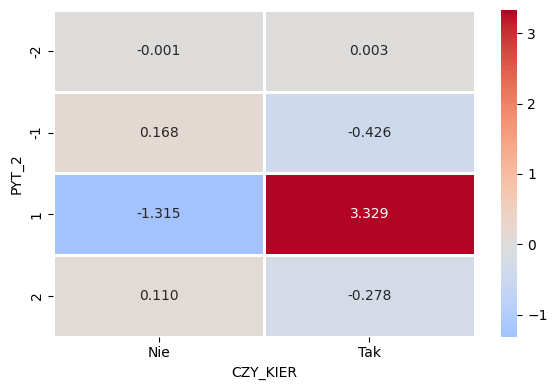

In [179]:
plt.figure(figsize=(6, 4))

sns.heatmap(
    chi2_P2CzK_stand_res,
    center=-0.05,
    annot=True,
    fmt=".3f",
    cmap="coolwarm",
    cbar=True,
    xticklabels=crosstab_P2CzK.columns,
    yticklabels=crosstab_P2CzK.index,
    linewidths=1
)

plt.ylabel('PYT_2')
plt.xlabel('CZY_KIER')
plt.tight_layout()
plt.show()

### ZADANIE 9
    Zapoznaj się z funkcję służącą do generowania realizacji wektorów losowych z rozkładu wielomianowego, a następnie korzystając z niej przeprowadź symulacje w celu oszacowania mocy testu Fishera oraz mocy testu chi-kwadrat Pearsona, generując dane z tabeli 2×2, w której p11 = 1/40, p12 = 3/40, p21 = 19/40,    p22 = 17/40. Symulacje wykonaj dla n = 50, n = 100 oraz n = 1000. Sformułuj wnioski.

In [180]:
p = [1/40, 3/40, 19/40, 17/40]
alpha = 0.05
tab_size = (2,2)
n = [50, 100, 1000]

$\huge \text{tutaj zweryfikować - dla domyślnej lambda\_ (Pearson) chi2 nie działa}$

In [181]:
def test_power(p, alpha, tab_size, n, M=500):
    chi2_rejected = 0
    fisher_rejected = 0
    for i in range(M):
        random_vector = np.random.multinomial(n, p)
        random_vector = random_vector.reshape(tab_size)

        chi2_results = chi2_contingency(random_vector, lambda_="log-likelihood")
        fisher_results = fisher_exact(random_vector)

        if chi2_results.pvalue < alpha:
            chi2_rejected += 1
        if fisher_results.pvalue < alpha:
            fisher_rejected += 1   
                     
    power_chi2 = chi2_rejected / M
    power_fisher = fisher_rejected / M

    return power_chi2, power_fisher

In [182]:
chi2_power = np.zeros(len(n))
fisher_power = np.zeros(len(n))

for i, n_i in enumerate(n):
    chi2_power[i], fisher_power[i] = test_power(p, alpha, tab_size, n_i)

ValueError: The internally computed table of expected frequencies has a zero element at (np.int64(0), np.int64(0)).

In [ ]:
data_test_power = {
    "n": n,
    "Moc testu chi-kwadrat": chi2_power,
    "Moc testu Fishera": fisher_power
}

df_test_power = pd.DataFrame(data_test_power)
df_test_power

,n,Moc testu chi-kwadrat,Moc testu Fishera
0,50,0.094,0.132
1,100,0.264,0.310
2,1000,1.000,1.000


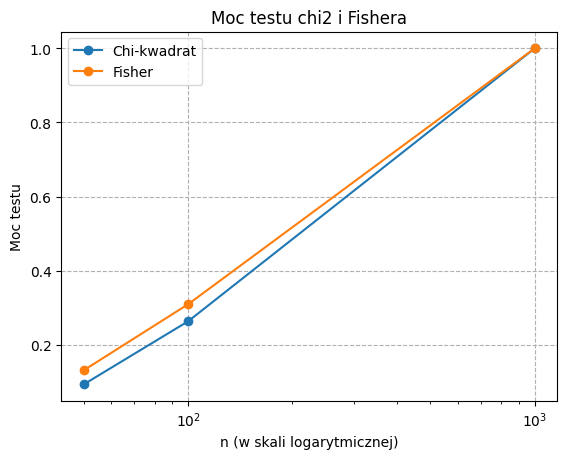

In [ ]:
plt.plot(n, chi2_power, label='Chi-kwadrat', marker='o')
plt.plot(n, fisher_power, label='Fisher', marker='o')

plt.legend()
plt.title('Moc testu chi2 i Fishera')
plt.grid(True, linestyle='--')
plt.xscale('log')
plt.xlabel('n (w skali logarytmicznej)')
plt.ylabel('Moc testu')
plt.show()

In [ ]:
# def test_power(p, alpha, tab_size, n, test_func, M=500):
#     rejected_count = 0
#     valid_runs = 0

#     for _ in range(M):
#         random_vector = np.random.multinomial(n, p)
#         random_vector = random_vector.reshape(tab_size)

#         try:
#             result = test_func(random_vector)
#             p_value = result.pvalue if hasattr(result, 'pvalue') else result[1]

#             if p_value < alpha:
#                 rejected_count += 1
#             valid_runs += 1

#         except ValueError:
#             continue

#     if valid_runs == 0:
#         return np.nan 

#     return rejected_count / valid_runs


### ZADANIE 10
    Napisz funkcję, która dla danych z tablicy dwudzielczej oblicza wartość poziomu krytycznego w teście niezależnosci opartym na ilorazie wiarogodnosci. Korzystając z napisanej funkcji, wykonaj test dla danych przeanalizowanych w zadaniu 8.

$\huge \text{tutaj zweryfikować}$

In [ ]:
# G-test: Funkcja scipy.stats.chi2_contingency z parametrem lambda_="log-likelihood" wykonuje test niezależności oparty na ilorazie wiarygodności (czyli tzw. G-test)

def likelihood_ratio_test_g(obs):
    stat, p, dof, _ = chi2_contingency(obs, lambda_="log-likelihood")
    return stat, p, dof

- test dla danych przeanalizowanych w zadaniu 8 (pamiętajmy, że przyjmujemy $\alpha=0.01$)

In [ ]:
stat, p, dof = likelihood_ratio_test_g(crosstab_P2CzK.values)

print(f"Statystyka G: {stat:.4f}, p-value: {p:.4f}, stopnie swobody: {dof}")

Statystyka G: 8.3285, p-value: 0.0397, stopnie swobody: 3


Jak można zauważyć:
$$ p{-}wartość = 0.0397 > \alpha = 0.01 $$
Oznacza to, że nie ma podstaw do odrzucenia hipotezy zerowej, zakładającej brak związku pomiędzy stopniem zadowolenia ze szkoleń w kontekście ich dopasowania do indywidualnych potrzeb w pierwszym badanym okresie a zajmowanym stanowiskiem.

W konsekwencji, przy poziomie istotności 1%, nie stwierdzono statystycznie istotnej zależności pomiędzy tymi zmiennymi — obserwowane różnice mogą być przypadkowe i nie wskazują na rzeczywisty związek w populacji.

## CZĘŚĆ IV i V

### ZADANIE 11
    Przeprowadzone wsród brytyjskich mężczyzn badanie trwające 20 lat wykazało, że odsetek zmarłych (na rok) z powodu raka płuc wynosił 0,00140 wsród osób palących papierosy i 0,00010 wsród osób niepalących. Odsetek zmarłych z powodu choroby niedokrwiennej serca wynosił 0,00669 dla palaczy i 0,00413 dla osób niepalących. Opisz związek pomiędzy paleniem papierosów a śmiercią z powodu raka płuc oraz związek pomiędzy paleniem papierosów a śmiercią z powodu choroby serca. Skorzystaj z różnicy proporcji, ryzyka względnego i ilorazu szans. Zinterpretuj wartości. Związek której pary zmiennych jest silniejszy?

Skorzystamy z następujących definicji:

- Ryzyko względne (RR): porównuje prawdopodobieństwo wystąpienia danego zdarzenia w grupie badanej (interwencyjnej) do grupy kontrolnej

$$
RR = \dfrac{IE/(IE + IN)}{CE/(CE + CN)}
$$

gdzie: 

$RR$ - ryzyko względne, 	

$IE$ - liczba przypadków zdarzenia w grupie interwencyjnej,

$IN$ - liczba przypadków braku zdarzenia w grupie interwencyjnej,

$CE$ - liczba przypadków zdarzenia w grupie kontrolnej,

$CN$ - liczba przypadków braku zdarzenia w grupie kontrolnej.

Wyniki można interpretować następująco:

RR > 1: ryzyko wystąpienia zdarzenia jest większe w grupie interwencyjnej niż w kontrolnej,

RR < 1: ryzyko wystąpienia zdarzenia jest mniejsze w grupie interwencyjnej,

RR = 1: brak różnicy pomiędzy grupami.

- Iloraz szans (ang. OR, odds ratio): stosunek szans wystąpienia danego zdarzenia w jednej grupie do szansy jego wystąpienia w innej grupie

$$
OR_{A/B} = \dfrac{\mathbb {P}(A)\cdot(1-\mathbb {P}(B))}{\mathbb {P}(B)\cdot(1-\mathbb {P}(A))}
$$

gdzie: $\mathbb {P}(A)$ to prawdopodobieństwo wystąpienia zdarzenia w grupie $A$.

Wyniki można interpretować następująco:

OR > 1: wyższe szanse wystąpienia zdarzenia w grupie A względem grupy B,

OR < 1: niższe szanse wystąpienia zdarzenia w grupie A,

OR = 1: brak różnicy w szansach między grupami.

In [ ]:
# Odsetek zmarłych z powodu raka płuc wśród palaczy i niepalaczy
lung_cancer_rate_smokers = 0.00140
lung_cancer_rate_nonsmokers  = 0.00010

lung_cancer_rate_diff = lung_cancer_rate_smokers - lung_cancer_rate_nonsmokers
lung_cancer_RR = lung_cancer_rate_smokers / lung_cancer_rate_nonsmokers
lung_cancer_OR = (lung_cancer_rate_smokers / (1 - lung_cancer_rate_smokers)) / (lung_cancer_rate_nonsmokers / (1 - lung_cancer_rate_nonsmokers))

# Odsetek zmarłych z powodu choroby niedokrwiennej serca wśród palaczy i niepalaczy
heart_disease_rate_smokers = 0.00669
heart_disease_rate_nonsmokers = 0.00413

heart_disease_rate_diff = heart_disease_rate_smokers - heart_disease_rate_nonsmokers
heart_disease_RR = heart_disease_rate_smokers / heart_disease_rate_nonsmokers
heart_disease_OR = (heart_disease_rate_smokers / (1 - heart_disease_rate_smokers)) / (heart_disease_rate_nonsmokers / (1 - heart_disease_rate_nonsmokers))

In [ ]:
data_british_man = {
    "Choroba": ["Rak płuc", "Choroba niedokrwienna serca"],
    "Odsetek zmarłych (palacze)": [lung_cancer_rate_smokers, heart_disease_rate_smokers],
    "Odsetek zmarłych (niepalacze)": [lung_cancer_rate_nonsmokers, heart_disease_rate_nonsmokers],
    "Różnica proporcji": [lung_cancer_rate_diff, heart_disease_rate_diff],
    "Ryzyko względne (RR)": [lung_cancer_RR, heart_disease_RR],
    "Iloraz szans (OR)": [lung_cancer_OR, heart_disease_OR]
}

df_british_man = pd.DataFrame(data_british_man)
df_british_man["Odsetek zmarłych (palacze)"] = df_british_man["Odsetek zmarłych (palacze)"].apply(lambda x: f"{x:.4f}")
df_british_man["Odsetek zmarłych (niepalacze)"] = df_british_man["Odsetek zmarłych (niepalacze)"].apply(lambda x: f"{x:.4f}")
df_british_man["Różnica proporcji"] = df_british_man["Różnica proporcji"].apply(lambda x: f"{x:.4f}")
df_british_man["Ryzyko względne (RR)"] = df_british_man["Ryzyko względne (RR)"].apply(lambda x: f"{x:.2f}")
df_british_man["Iloraz szans (OR)"] = df_british_man["Iloraz szans (OR)"].apply(lambda x: f"{x:.2f}")

df_british_man

,Choroba,Odsetek zmarłych (palacze),Odsetek zmarłych (niepalacze),Różnica proporcji,Ryzyko względne (RR),Iloraz szans (OR)
0,Rak płuc,0.0014,0.0001,0.0013,14.00,14.02
1,Choroba niedokrwienna serca,0.0067,0.0041,0.0026,1.62,1.62


Analizując otrzymane wyniki:

a) Rak płuc

Na podstawie różnicy proporcji można stwierdzić, że osoby palące charakteryzują się wyraźnie wyższą zachorowalnością na raka płuc w porównaniu do osób niepalących – różnica ta wynosi około 0.13%.

Dodatkowo, wartość ryzyka względnego wynosząca RR = 14 oznacza, że ryzyko zachorowania na raka płuc wśród palaczy jest 14 razy wyższe niż wśród osób niepalących. Podobnie, iloraz szans OR = 14.02 również wskazuje na znacznie wyższe szanse wystąpienia choroby w grupie palaczy.

Otrzymane wyniki są zgodne z intuicją oraz dotychczasową wiedzą medyczną – palenie papierosów znacząco zwiększa ryzyko zachorowania na raka płuc.

b) Choroba niedokrwienia serca

W przypadku choroby niedokrwiennej serca zaobserwowano mniejszą, lecz nadal zauważalną zależność pomiędzy paleniem a zachorowalnością. Różnica proporcji wynosi 0.26%, co oznacza, że osoby palące częściej chorują na niedokrwienie serca niż osoby niepalące.

Jednakże wartości ryzyka względnego i ilorazu szans (RR = 1.62, OR = 1.62) wskazują, że zależność ta jest znacznie słabsza niż w przypadku raka płuc. Oznacza to, że średnie ryzyko zachorowania na chorobę niedokrwienną serca wśród palaczy jest około 1.6 razy wyższe niż u niepalących.

### ZADANIE 12
    Tabela 1 przedstawia wyniki dotyczące śmiertelności kierowców i pasażerów w wypadkach samochodowych na Florydzie w 2008 roku, w zależności od tego, czy osoba miała zapięty pas bezpieczeństwa czy nie.

<div align="center">

| | Śmiertelny | Nieśmiertelny |
| ----------- | ----------- | ----------- |
| **Bez pasów** | 1085 | 55 623 |
| **Z pasami** | 703 | 441 239 |

</div> 
<br>
<div align="center">
Table 1: Wyniki dotyczące śmiertelności w wypadkach samochodowych na Florydzie w 2008 roku.
</div>

        a) Oszacuj warunkowe prawdopodobieństwo śmierci w wypadku ze względu na drugą zmienną, tj. dla kierowców i pasażerów, którzy użyli pasa bezpieczeństwa oraz dla kierowców i pasażerów, który nie użyli pasa bezpieczeństwa.
        b) Oszacuj warunkowe prawdopodobieństwo użycia pasa bezpieczeństwa ze względu na drugą zmienną, tj. dla kierowców i pasażerów ze śmiertelnymi obrażeniami oraz dla kierowców i pasażerów, którzy przeżyli wypadek.
        c) Jaki jest najbardziej naturalny wybór dla zmiennej objaśnianej w tym badaniu? Dla takiego wyboru wyznacz i zinterpretuj różnice proporcji, ryzyko względne oraz iloraz szans. Dlaczego wartości ryzyka względnego i ilorazu szans przyjmują zbliżone wartości?

In [ ]:
death_with_belts = 703
death_no_belts = 1085
total_death = death_with_belts + death_no_belts

alive_with_belts = 441239
alive_no_belts = 55623
total_alive = alive_with_belts + alive_no_belts

total = total_death + total_alive

a) Warunkowe prawdopodobieństwo śmierci w zależności od użycia pasów bezpieczeństwa

In [ ]:
# pod warunkiem użycia pasów
cond_prob_death_with_belts = death_with_belts / (death_with_belts + alive_with_belts)
print("Prawdopodobieństwo śmierci pod warunkiem użycia pasów bezpieczeństwa: ", cond_prob_death_with_belts)

# pod warunkiem nieużycia pasów
cond_prob_death_no_belts = death_no_belts / (death_no_belts + alive_no_belts)
print("Prawdopodobieństwo śmierci pod warunkiem nieużycia pasów bezpieczeństwa: ", cond_prob_death_no_belts)

Prawdopodobieństwo śmierci pod warunkiem użycia pasów bezpieczeństwa:  0.0015907064727950727
Prawdopodobieństwo śmierci pod warunkiem nieużycia pasów bezpieczeństwa:  0.019133102913169216


Zgodnie ze zdroworozsądkowym założeniem, stosowanie pasów bezpieczeństwa powinno obniżać ryzyko śmierci w wypadkach drogowych. Wyniki potwierdzają tę hipotezę. Prawdopodobieństwo śmierci pod warunkiem użycia pasów bezpieczeństwa wynosi 0.00159, podczas gdy pod warunkiem nieużycia pasów bezpieczeństwa wynosi 0.01935.

b) Warunkowe prawdopodobieństwo użycia pasów w zależności od wyniku wypadku

In [ ]:
# pod warunkiem użycia pasów
cond_prob_with_belts_death = death_with_belts / (death_with_belts + death_no_belts)
print("Prawdopodobieństwo użycia pasów bezpieczeństwa pod warunkiem śmierci: ", cond_prob_with_belts_death)

# pod warunkiem użycia pasów
cond_prob_no_belts_alive = alive_with_belts / (alive_with_belts + alive_no_belts)
print("Prawdopodobieństwo użycia pasów bezpieczeństwa po warunkiem przeżycia: ", cond_prob_no_belts_alive)

Prawdopodobieństwo użycia pasów bezpieczeństwa pod warunkiem śmierci:  0.3931767337807606
Prawdopodobieństwo użycia pasów bezpieczeństwa po warunkiem przeżycia:  0.8880514106532599


Rozpatrując sytuację odwrotnie, można oszacować, jak fakt przeżycia lub śmierci wpływa na prawdopodobieństwo użycia pasów bezpieczeństwa. Prawdopodobieństwo użycia pasów wśród osób, które przeżyły wynosi $0.888$. Prawdopodobieństwo użycia pasów wśród osób, które zginęły: $0.393$

Zatem osoby, które przeżyły wypadek, znacznie częściej (ponad dwukrotnie częściej) miały zapięte pasy w porównaniu do tych, które poniosły śmierć.

c) Zmienna objaśniana i miary efektu

NNajbardziej naturalnym wyborem dla zmiennej objaśnianej jest status osoby po wypadku (śmierć vs. przeżycie), a zmienną objaśniającą – użycie pasów bezpieczeństwa. Taki wybór wynika z chęci zbadania wpływu stosowania pasów na ryzyko śmierci.

- różnica proporcji

In [ ]:
death_belts_prop_diff = cond_prob_death_no_belts - cond_prob_death_with_belts 
death_belts_prop_diff

0.017542396440374145

Oznacza to, że brak pasów zwiększa bezwzględne ryzyko śmierci o $1.75 \%$.

- ryzyko względne (RR)

In [ ]:
death_belts_RR = cond_prob_death_no_belts / cond_prob_death_with_belts
death_belts_RR

12.028053723544565

Osoby bez pasów są około 12 razy bardziej narażone na śmierć niż osoby z zapiętymi pasami.

- iloraz szans (OR)

In [ ]:
death_belts_OR = (cond_prob_death_no_belts / (1 - cond_prob_death_no_belts)) / (cond_prob_death_with_belts / (1 - cond_prob_death_with_belts))
death_belts_OR

12.243170461046063

Zarówno RR, jak i OR mają zbliżone wartości (ok. 12), co jest typowe dla rzadkich zdarzeń (takich jak śmierć w wypadku), ponieważ w takich przypadkach szanse i prawdopodobieństwa przyjmują podobne wartości, a różnice między nimi są minimalne.

### ZADANIE 13
    Oblicz wartości odpowiednich miar współzmienności (współczynnik tau lub współczynnik gamma) dla zmiennych:
        • stopień zadowolenia ze szkoleń w kontekście dopasowania do indywidualnych potrzeb w pierwszym badanym okresie i zajmowane stanowisko,
        • stopień zadowolenia ze szkoleń w kontekście dopasowania do indywidualnych potrzeb w pierwszym badanym okresie i staż pracy,
        • zajmowane stanowisko i staż pracy.

- stopień zadowolenia ze szkoleń w kontekście dopasowania do indywidualnych potrzeb w pierwszym badanym okresie i zajmowane stanowisko

In [ ]:
kendalltau(data['PYT_2'], data['CZY_KIER'])

SignificanceResult(statistic=np.float64(-0.013012659367902335), pvalue=np.float64(0.8485756001088873))

- stopień zadowolenia ze szkoleń w kontekście dopasowania do indywidualnych potrzeb w pierwszym badanym okresie i staż pracy

In [ ]:
kendalltau(data['PYT_2'], data['STAŻ'])

SignificanceResult(statistic=np.float64(0.04805720025595951), pvalue=np.float64(0.467191021174312))

- zajmowane stanowisko i staż pracy

In [ ]:
kendalltau(data['CZY_KIER'], data['STAŻ'])

SignificanceResult(statistic=np.float64(0.28161663064776427), pvalue=np.float64(4.199376879536726e-05))

### ZADANIE 14
    Na podstawie informacji przedstawionych na wykładzie napisz własną funkcję do przeprowadzania analizy korespondencji. Funkcja powinna przyjmować jako argument tablicę dwudzielczą i zwracać obliczone wartości odpowiednich wektorów i macierzy, współrzędnych punktów oraz odpowiedni wykres. Korzystając z napisanej funkcji wykonaj analizę korespondencji dla danych dotyczących stopnia zadowolenia ze szkoleń w kontekście dopasowania do indywidualnych potrzeb w pierwszym badanym okresie oraz stażu pracy.

-------------------------------------------------------

## ZADANIA DODATKOWE

### ZADANIE *1
    Napisz funkcję, która dla dwóch wektorów danych oblicza wartość poziomu krytycznego (p-value) w teście opartym na korelacji odległości. Następnie dla wygenerowanych danych zweryfikuj hipotezę o niezależności przy użyciu napisanej funkcji.

**Korelacja odległości (distance correlation)** jest miarą zależności między zmiennymi losowymi, która – w odróżnieniu od klasycznego współczynnika korelacji Pearsona – wykrywa zarówno zależności liniowe, jak i nieliniowe. Wartość korelacji odległości wynosi zero wtedy i tylko wtedy, gdy zmienne są niezależne. Jest to zatem silne narzędzie statystyczne do testowania hipotezy niezależności.

Aby zweryfikować hipotezę:

- $ H_0 $: zmienne X i Y są niezależne,  
- $ H_1 $: zmienne X i Y są zależne,

stosowany jest **test permutacyjny**, który polega na porównaniu wartości obserwowanej statystyki korelacji odległości z rozkładem tej statystyki uzyskanym poprzez wielokrotne losowe permutowanie jednej ze zmiennych. Wartość p oblicza się jako stosunek liczby permutacji, dla których permutowana statystyka była większa lub równa statystyce obserwowanej, do liczby wszystkich permutacji.


In [70]:
from scipy.spatial.distance import pdist, squareform

def distance_matrix(X):
    return squareform(pdist(X[:, None] if X.ndim == 1 else X, metric='euclidean'))

def double_centered(A):
    n = A.shape[0]
    row_mean = A.mean(axis=1, keepdims=True)
    col_mean = A.mean(axis=0, keepdims=True)
    total_mean = A.mean()
    return A - row_mean - col_mean + total_mean

def distance_covariance(X, Y):
    A = double_centered(distance_matrix(X))
    B = double_centered(distance_matrix(Y))
    return np.mean(A * B)

def distance_correlation(X, Y):
    dcov_xy = distance_covariance(X, Y)
    dcov_xx = distance_covariance(X, X)
    dcov_yy = distance_covariance(Y, Y)
    if dcov_xx == 0 or dcov_yy == 0:
        return 0
    return np.sqrt(dcov_xy) / np.sqrt(np.sqrt(dcov_xx * dcov_yy))

def distance_correlation_test(X, Y, num_permutations=1000, seed=None):
    np.random.seed(seed)
    observed = distance_correlation(X, Y)
    count = 0
    for _ in range(num_permutations):
        permuted_Y = np.random.permutation(Y)
        permuted_corr = distance_correlation(X, permuted_Y)
        if permuted_corr >= observed:
            count += 1
    p_value = count / num_permutations
    return observed, p_value

In [72]:
np.random.seed(0)
n = 100
X = np.random.normal(0, 1, n)
Y = X**2 + np.random.normal(0, 1, n)  # nieliniowa zależność

stat, p_val = distance_correlation_test(X, Y, num_permutations=1000)
print(f"Korelacja odległości: {stat}")
print(f"P-value: {p_val}")


Korelacja odległości: 0.40269666862692627
P-value: 0.0


### ZADANIE *2
    Dla zadanych π1 oraz π2 pokaż, że wartość ryzyka względnego (RR) nie jest bardziej oddalona od wartości 1 (wartość odpowiadająca niezależności) niż wartość odpowiadającego ilorazu szans (OR).

### ZADANIE *3
    Niech D oznacza posiadanie pewnej choroby, a E pozostawanie wystawionym na pewny czynnik ryzyka. W badaniach epidemiologicznych definuje się miarę AR nazywaną ryzykiem przypisanym (ang. attributable risk).
        a) Niech P(E′) = 1−P(E), wówczas AR = [P(D)−P(D|E′)]/P(D). Wyjaśnij interpretację miary na podstawie wzoru.
        b) Pokaż, że AR ma związek z ryzykiem względnym, tzn.:
                AR=[P(E)(RR−1)]/[1+P(E)(RR−1)]